In [0]:
import os
import uuid
import yaml

from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.common_utils import cleanup, create_gif_from_images, generateSamples, restore_checkpoint_status, save_images, save_model_state


# set the tensorflow verbosity
tf.logging.set_verbosity(tf.logging.DEBUG)

In [4]:
# get the mnist dataset from tensorflow
mnist = tf.contrib.learn.datasets.load_dataset('mnist')
training_data = mnist.train.images
testing_data = mnist.test.images
validation_data = mnist.validation.images

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
NUM_DIMS = 28
NUM_SAMPLES = training_data.shape[0]
FLATTENED_DIMS = 784

"""
Defines the experiment id for a experiment.
Make sure to update the experiment id when running the code using a new set of hyperparameters
"""
experiment_id = '5'
# specify the directory where to save the samples generated by the generator
SRC_DIR = './model_data_wgan/experiment_{}'.format(experiment_id)

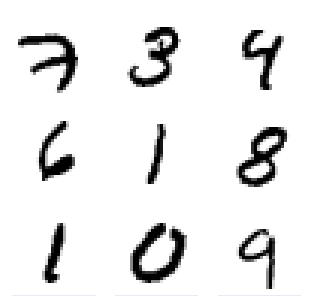

In [6]:
save_images(training_data[0:9,:], show=True, dpi=125)

In [0]:
"""
starting_learning_rate : learning_rate used during the training procedure
c_max : Upper limit for weight clipping
c_min : Lower limit for weight clipping
k : The number of steps used to train the discriminator or critic
noise_dim : The number of dimensions of the noise input to the generator net
dropout_rate : The rate of dropout used in the dicriminator network
num_steps: The number of steps to train the nets for
m : The number of samples used for training the nets (half of the batch size)
noise_variance : The variance of noise for sampling noise samples
"""
# define the learning hyperparameters as a dictionary
config = {
    "starting_learning_rate":0.0002,
    "c_max":0.05,
    "c_min":-0.05,
    "initial_k":100,
    "init_point":1,
    "k":5,
    "noise_dim":100,
    "decay_steps":10000,
    "decay_rate":0.96,
    "num_steps":10000,
    "m":64,
    "noise_variance":0.02,

    # define the layer hyperparameters
    "gen_layers_units":{
        "projection_dim" : 16,
        "deconv_1" : 512,
        "deconv_2" : 256,
        "deconv_3" : 128
    },
    "dis_layers_units":{
        "conv_1" : 128,
        "conv_2" : 256,
        "conv_3" : 512
    },
    "special_comments": 'Trained with initializing the disc with some initial iterations to provide a good starting point \
                         Also changed the clipping values to loosen the Lipschitz bound'
}

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(config['starting_learning_rate'], 
                                           global_step, 
                                           config['decay_steps'], 
                                           config['decay_rate'], 
                                           staircase=True)

In [0]:
# define the input placeholders
X = tf.placeholder(dtype=tf.float32, shape=(None, NUM_DIMS, NUM_DIMS, 1), name='Training-input')
Z = tf.placeholder(dtype=tf.float32, shape=(None, config['noise_dim']), name='Noise-input')
batch_norm = tf.placeholder(dtype=tf.bool, name='Generator-batchnorm')

# define the clipping scalars
C_MAX = tf.constant(config['c_max'], dtype=tf.float32, name='Clipping_max_factor')
C_MIN = tf.constant(config['c_min'], dtype=tf.float32, name='Clipping_min_factor')

# this noise sample is used to visualize the generator learning over time
base_noise_sample = tf.Variable(np.random.normal(size=(9, config['noise_dim']), scale=config['noise_variance']), 
                                dtype=tf.float32, 
                                expected_shape=(9, config['noise_dim']))

In [0]:
def generator(noise_samples):
    
    with tf.variable_scope('GEN', reuse=tf.AUTO_REUSE):
        
        # project the noise to a vector
        projected_samples = tf.layers.dense(noise_samples, 16, activation=tf.nn.relu)
        
        # reshape the projected samples to a 4D tensor
        noise_input = tf.reshape(projected_samples, [-1, 4, 4, 1])
        
        # define the generator network
        
        ####  First conv layer ####
        outputg_conv_1 = tf.layers.conv2d_transpose(noise_input, filters=config['gen_layers_units']['deconv_1'], kernel_size=(4, 4), activation=tf.nn.relu)
        outputg_batchnorm_1 = tf.layers.batch_normalization(outputg_conv_1, scale=False, training=batch_norm)
        
        ####  Second conv layer ####
        outputg_conv_2 = tf.layers.conv2d_transpose(outputg_batchnorm_1, filters=config['gen_layers_units']['deconv_2'], kernel_size=(4, 4), activation=tf.nn.relu)
        
        ####  Third conv layer ####
        outputg_conv_3 = tf.layers.conv2d_transpose(outputg_conv_2, filters=config['gen_layers_units']['deconv_3'], kernel_size=(4, 4), activation=tf.nn.relu)
        
        # the output of the generator network
        outputg = tf.layers.conv2d_transpose(outputg_conv_3, filters=1, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.tanh)
    
    return outputg

In [0]:
def discriminator(x):
    
    with tf.variable_scope('DIS', reuse=tf.AUTO_REUSE):
        
        # define the discriminator network
        
        ####  First conv layer ####
        outputd_conv_1 = tf.layers.conv2d(x, filters=config['dis_layers_units']['conv_1'], kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.leaky_relu)
#         outputd_dropout_1 = tf.layers.dropout(outputd_conv_1, rate=config['dropout_rate'], training=True)
        
        ####  Second conv layer ####
        outputd_conv_2 = tf.layers.conv2d(outputd_conv_1, filters=config['dis_layers_units']['conv_2'], kernel_size=(4, 4), activation=tf.nn.leaky_relu)
        
        ####  Third conv layer ####
        outputd_conv_3 = tf.layers.conv2d(outputd_conv_2, filters=config['dis_layers_units']['conv_3'], kernel_size=(4, 4), activation=tf.nn.leaky_relu)
        outputd_flatten_3 = tf.layers.flatten(outputd_conv_3)
        
        # the output of the discriminator network (The classification probability)
        logit = tf.layers.dense(outputd_flatten_3, 1, activation=None)
        outputd = tf.nn.sigmoid(logit)
    
    return (logit, outputd)

In [11]:
# define the network ops
generator_output = generator(Z)
d_real_logit, d_real_output = discriminator(X)
d_fake_logit, d_fake_output = discriminator(generator_output)

# define the loss ops
D_loss = tf.reduce_mean(d_real_logit - d_fake_logit)
G_loss = tf.reduce_mean(d_fake_logit)

# define the optimizer ops
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GEN")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="DIS")

clipping_op = [var.assign(tf.clip_by_value(var, C_MIN, C_MAX)) for
                                         var in disc_vars]

# define the update ops to run batch normalization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    d_optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(D_loss, var_list=disc_vars)
    g_optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(G_loss, var_list=gen_vars)

# define the session variable
saver = tf.train.Saver()
checkpoint_path = os.path.join(SRC_DIR, 'checkpoints', 'model-{}.ckpt'.format(experiment_id))
tmp_dir_path = os.path.join(SRC_DIR, 'tmp')

sess = tf.InteractiveSession()

# restore the checkpoint status for this experiment
status = restore_checkpoint_status(saver, sess, checkpoint_path)
if not status:
    sess.run(tf.global_variables_initializer())
    # remove the contents of the tmp location
    if(os.path.exists(tmp_dir_path)):
        cleanup(tmp_dir_path)
    
# define the optimization procedure
def optimize():
        
    for epoch_idx in range(config["num_steps"]):
        status = epoch_idx % 500
        k = config['initial_k']
        if epoch_idx > config['init_point']:
          k = config['k']
        for train_idx in range(k):
      
            training_batch, _ = mnist.train.next_batch(batch_size=config['m'])
            training_batch = np.reshape(training_batch, newshape=(config['m'], NUM_DIMS, NUM_DIMS, 1))
#             optimize the discriminator network
            _, discriminator_loss, _ = sess.run([d_optimizer, D_loss, clipping_op], feed_dict={Z:generateSamples(config['m'], config['noise_dim'], config['noise_variance']), 
                                                                               X:training_batch, 
                                                                               batch_norm:True})

            if(status == 0):
              print('Step {}: D-Loss:{}'.format(epoch_idx, discriminator_loss))
                
#         optimize the generator network
        _, generator_loss = sess.run([g_optimizer, G_loss], feed_dict={Z:generateSamples(config['m'], config['noise_dim'], config['noise_variance']), 
                                                                       batch_norm:True})
        
        if(epoch_idx % 100 == 0):
            # run the generator on a small number of samples
            generator_sample_output = sess.run(generator_output, feed_dict={Z:sess.run(base_noise_sample), batch_norm:False})
#             save the image
            img_id = str(uuid.uuid4())
            save_images(generator_sample_output, tmp_path=tmp_dir_path, save=True, id=str(uuid.uuid4())[:5], dpi=125)
    
        if(status == 0):
            print('Step {}: G-Loss:{}'.format(epoch_idx, generator_loss))
#             checkpoint the training
            save_model_state(saver, sess, checkpoint_path)

Checkpoint found for this experiment.Restoring variables.....
INFO:tensorflow:Restoring parameters from ./model_data_wgan/experiment_5/checkpoints/model-5.ckpt


In [12]:
optimize()

Step 0: D-Loss:-2835.303466796875
Step 0: D-Loss:-2276.114501953125
Step 0: D-Loss:-3055.68994140625
Step 0: D-Loss:-2787.3125
Step 0: D-Loss:-774.0115966796875
Step 0: D-Loss:-2728.407958984375
Step 0: D-Loss:-5031.904296875
Step 0: D-Loss:-1519.4141845703125
Step 0: D-Loss:-6852.41259765625
Step 0: D-Loss:-21.247314453125
Step 0: D-Loss:-9823.296875
Step 0: D-Loss:-3709.521484375
Step 0: D-Loss:-5650.0341796875
Step 0: D-Loss:-3895.86572265625
Step 0: D-Loss:-3469.7978515625
Step 0: D-Loss:-5664.97265625
Step 0: D-Loss:-4898.7890625
Step 0: D-Loss:-7057.484375
Step 0: D-Loss:-7449.3369140625
Step 0: D-Loss:-7004.84375
Step 0: D-Loss:-18537.841796875
Step 0: D-Loss:-11843.1689453125
Step 0: D-Loss:-6151.857421875
Step 0: D-Loss:-12694.03125
Step 0: D-Loss:-13268.666015625
Step 0: D-Loss:-8374.74609375
Step 0: D-Loss:-10203.078125
Step 0: D-Loss:-4227.005859375
Step 0: D-Loss:-8964.115234375
Step 0: D-Loss:-14151.279296875
Step 0: D-Loss:-6369.83203125
Step 0: D-Loss:-12686.9931640625


Creating gif from the images


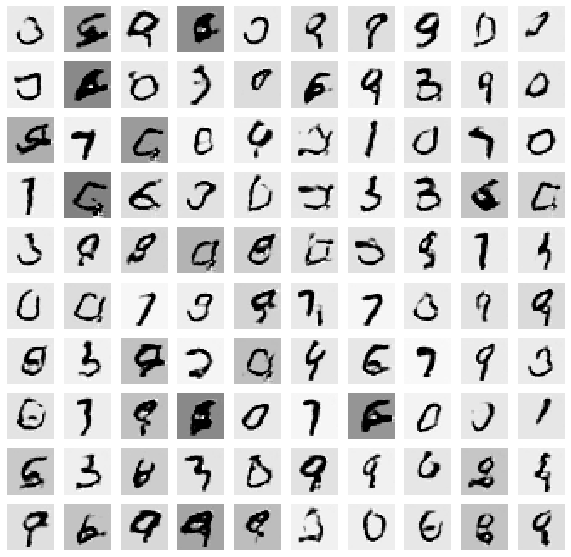

In [13]:
def plot_test_images(session, generator_op):
    
    noise_test = np.random.normal(scale=config['noise_variance'], size=(100, config['noise_dim']))
    images = sess.run(generator_op, feed_dict={Z:noise_test, batch_norm:False})
    # plot the generated test images
    save_images(images, show=True)
    
plot_test_images(sess, generator_output)

# create a gif of the images in the directory and store
src = os.path.join(SRC_DIR, 'tmp')
dst = os.path.join(SRC_DIR, 'gifs/visualization.gif')
create_gif_from_images(src, dst)

# save the network configuration to a file
config_file = os.path.join(SRC_DIR, 'config.yaml')
with open(config_file, 'w') as writer:
    yaml.dump(config, writer, default_flow_style=False)
    
# cleanup(os.path.join(SRC_DIR, 'tmp'))
# cleanup(os.path.join(SRC_DIR, 'gifs'))
# cleanup(os.path.join(SRC_DIR, 'checkpoints'))